<a href="https://colab.research.google.com/github/Ogunfool/Examining-the-effect-of-hyperparameters-and-Exploring-the-relationship-between-hyperparameters/blob/main/Image_Classification_With_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer learning involves using a pre-trained network to train your network. It can serve as the main model for your object classification problem or it might need some finetuning.
A pretrained network is a network that have been previously well trained (good generalization ablilities) on very large datasets. The intuition behind transfer learning for image classification is that if the network was originally trained on large datasets and it learnt generic image features, then it can serve as a generic  model for the visual world.
It is however inpertant to use pretrained models that were trained on images in similar domains with the images you want to classify. If the image classifiaction tasks have very different domains, e.g, using a dog, cat classification pretrained model for cancerous cell classification problems, it might be more efficient to build a new network from scratch; but it is worth the try. 

Two ways to customize a pretrained model.

1.   Use as it is: Simple add a new classifier (CNN and output layers) to the pretrained network and retrain. This leverages the representations learned by previous networks or from previous dataset. The base pretrained network is not retrained, just the new classification network layers are trained to repurpose the feature maps learnt previoulsy for the new dataset.
2.  Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

The major difference btw the first and second method (fine-tuning) is that for the first method, the base model is not retrained, just the new classifier layer(s) are retrained BUT for finetuning method, the base and new models are retrained with exception of the batch normalization layers.



In [ ]:
#  Load Relevant Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from tensorflow import keras
from keras import losses, optimizers, layers, activations, regularizers

In [ ]:
import os
import PIL
import PIL.Image
# import tensorflow_datasets as tfds

Configure Data Input Pipeline

In [ ]:
import pathlib
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)  # It downloads data from url if it is not already in cache
data_dir = pathlib.Path(archive).with_suffix('')

135118848/135107811 [==============================] - 22s 0us/step


In [ ]:
data_dir

WindowsPath('C:/Users/Oluwaseyi/.keras/datasets/cifar10')

In [ ]:
# See directory list and classes
print(os.listdir(data_dir))
train_classes = os.listdir(str(data_dir) + "/train")
print(train_classes)
print('No. of classes:', len(train_classes))

val_classes = os.listdir(str(data_dir) + "/test")

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
No. of classes: 10


In [ ]:
# Closer look at the classes
airplane_files = os.listdir(str(data_dir) + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

ship_test_files = os.listdir(str(data_dir) + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of training examples for airplanes: 5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']
No. of test examples for ship: 1000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [ ]:
#  Use the tf.keras.utils.image_dataset_from_directory
batch_size = 192
img_height = 32
img_width = 32

# Train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir) + "/train",
  shuffle=True,
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir) + "/test",
  shuffle=True,
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Class Name Attribute of the dataset - You can find the class names in the class_names attribute on these datasets.
train_class_names = train_ds.class_names
print(train_class_names)
val_class_names = val_ds.class_names
print(val_class_names)

Found 50000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Let's use the original test set as validation set and the whole train set as training data
# Rather than splitting the train set to : Train - val, split val set to: val - test.
# To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 43
Number of test batches: 10


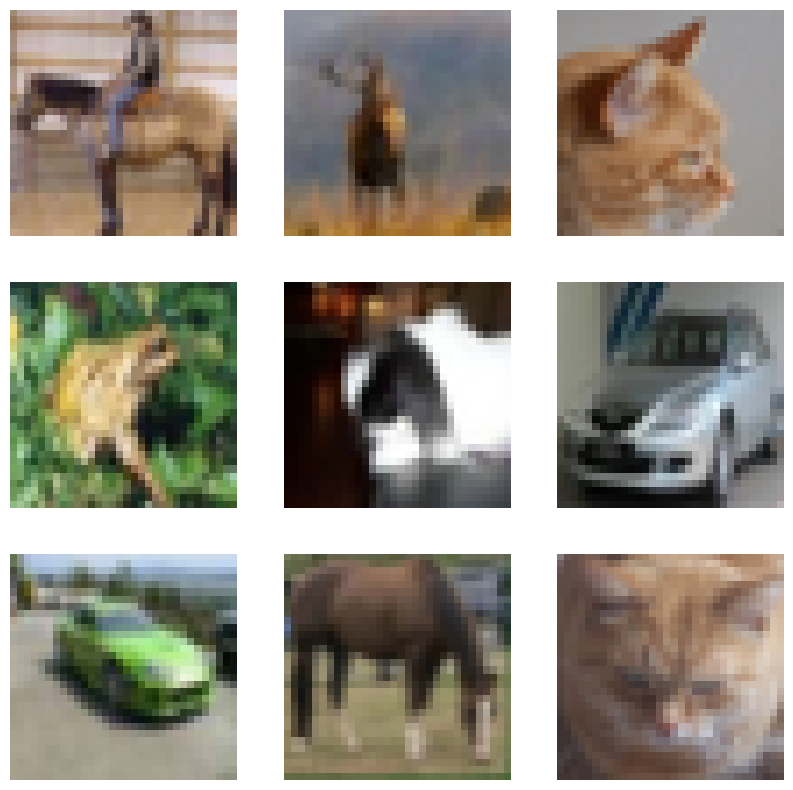

In [ ]:
# Plot some images
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"));
    # plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Cache and prefetch for more efficient training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)  # dataset.cache().prefetch()
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

USING TRANSFER LEARNING FOR CLASSIFICATION: CREATING THE BASE MODEL/CONVNETS.

1.   Instantiate base model: Create a base model from the pretrained model.When instantiating the base model, specify the layers of the pretrained that should be removed. In this case the bottleneck layer (the flattened dense and output layers) is removed and a new convnet classifier will be added and trained from scratch.
2.   Feature Extraction: Basically do a forward pass of the dataset through the network.
1.   After using the base model as a feature extractor, you can then freeze the base model by setting layer.trainable = False.
2.   Add a clasification head to the frozen base (Classification head = Dense layer(s) + Output layer).

1.   To add flattened dense layers after conv layers, flatten the output from the feature extractor by taking the average (From 32,5,5,1280 to 32,1280) and add the output dense layer by simply adding a tf.keras.layers.Dense with the no of classes as an argument. 
2.   Build the model by chaining together the preprocessing (data argumentation and rescaling), base model, feature extractor, and new classifier.

1.   Compile the model, See model summary and train model.
2.   List item



DATA ARGUMENTATION

In [ ]:
# Data augumentation layers in a sequential pipeline
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

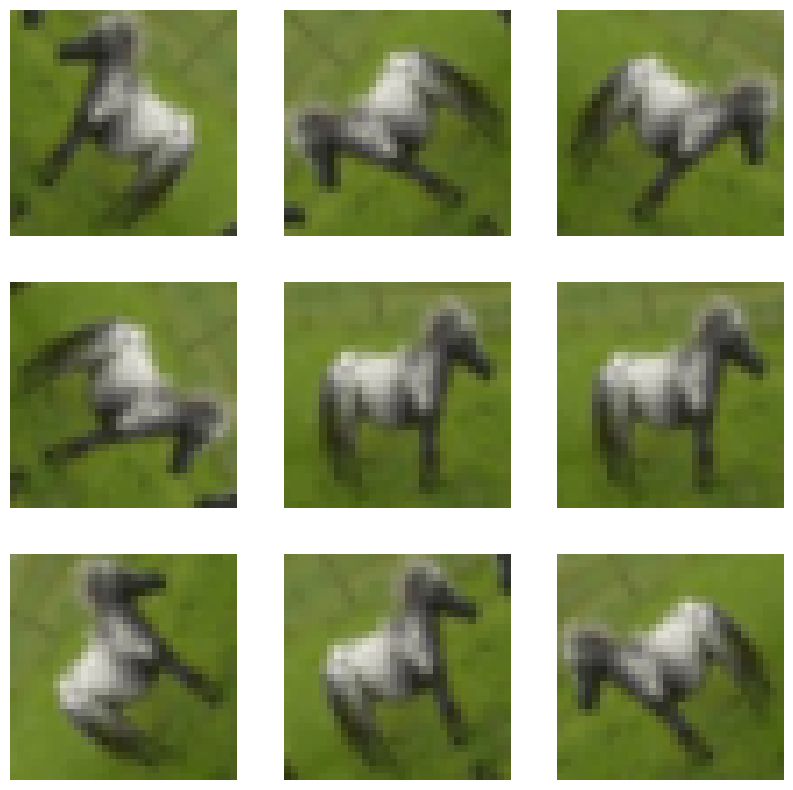

In [ ]:
# Let's repeatedly apply these layers to the same image and see the result.
# This si why data argumentation is powerful, everytime we start a new training epoch, a different transformation is done to all the images
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

FEATURE SCALING.

In [ ]:
rescale = tf.keras.layers.Rescaling(1/255)

# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Create the base model from pretrained convnets.


*   We will create the base model from RESNET pretrained model. EXPLAIN THE RESNEST MODEL......
*   Pick the layer of the pretrained model to use for feature extraction or decide which layers to be removed. We will be removing the last classification (Fully connected layer) OR be choosing the last layer before the flatten operation as the feature extraction layer (This layer is called the bottleneck layer).




In [ ]:
# Create the base model from the pre-trained model RESNET
IMG_SHAPE = (img_height,) + (img_width,) + (3,)
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# Feature Extraction - Let's see the effect - Feature Batch size
# This simply shows what will happen when you pass data to your basemodel during re-training (Note, we are using the base model just for inferencing)
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)   # Simple just pass images to the instantiated base model
print(feature_batch.shape)

94683136/94668760 [==============================] - 13s 0us/step
(192, 1, 1, 2048)


The feature extractor converts a (32,32,3) image to a (1,1,2048) image. These output will then be flattened.

FREEZE CONVOLUTIONAL BASE OR BASE MODEL.

In [ ]:
base_model.trainable = False

# See abse model summary
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 18, 18, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

ADD A CLASSIFICATION HEAD - use a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a vector element per image (Apply it on the feature batch) - Basically a more intentional flatening process.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(192, 2048)


In [ ]:
# Apply dense layer for output layer - We are using a single fully connected layer to the output (You can add more if need be)
prediction_layer = tf.keras.layers.Dense(10)  
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(192, 10)


CHAIN ALL TOGETHER TO BUILD FINAL MODEL USING THE FUNCTIONAL API.

*   Build model - compile model and train model.
*   List item



In [ ]:
# The tf.keras.Input layer returnss a symbolic tensor - FUNCTIONAL API
inputs = tf.keras.Input(shape=(32,32, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)  # x here is the feature batch
x = global_average_layer(x)  # x here is the averaged, flattened batch
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)   # x here is the output layer
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model summary
model.summary()

len(model.trainable_variables)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490 

2

It can be observed below, that the initial accuracy is very low - Let's see the improvement after training.

In [ ]:
# Do a forward pass before training to see the model effectiveness
# To do a forward pass, just instantiate the model (The weights are instantiated) and pass data into it (Linear combination)
initial_epochs = 10
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

43/43 [==============================] - 7s 87ms/step - loss: 2.3427 - accuracy: 0.0941
initial loss: 2.34
initial accuracy: 0.09


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
261/261 [==============================] - 28s 102ms/step - loss: 2.2969 - accuracy: 0.1352 - val_loss: 2.2397 - val_accuracy: 0.1754
Epoch 2/10
261/261 [==============================] - 10s 36ms/step - loss: 2.2114 - accuracy: 0.2003 - val_loss: 2.1920 - val_accuracy: 0.2090
Epoch 3/10
261/261 [==============================] - 10s 37ms/step - loss: 2.1650 - accuracy: 0.2250 - val_loss: 2.1571 - val_accuracy: 0.2302
Epoch 4/10
261/261 [==============================] - 10s 36ms/step - loss: 2.1337 - accuracy: 0.2440 - val_loss: 2.1291 - val_accuracy: 0.2519
Epoch 5/10
261/261 [==============================] - 10s 36ms/step - loss: 2.1109 - accuracy: 0.2516 - val_loss: 2.1151 - val_accuracy: 0.2527
Epoch 6/10
261/261 [==============================] - 10s 36ms/step - loss: 2.0901 - accuracy: 0.2608 - val_loss: 2.0971 - val_accuracy: 0.2593
Epoch 7/10
261/261 [==============================] - 10s 36ms/step - loss: 2.0787 - accuracy: 0.2656 - val_loss: 2.0824 - val_accuracy

In [ ]:
# Helper function that plots, saves and shows plots
def plot_loss_accuracy(filename):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.savefig(filename + '.png')
  plt.show()

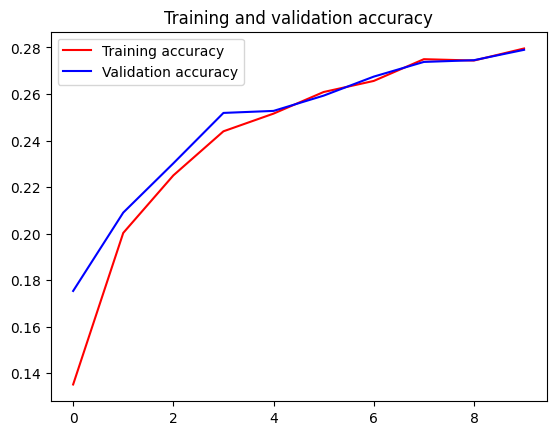

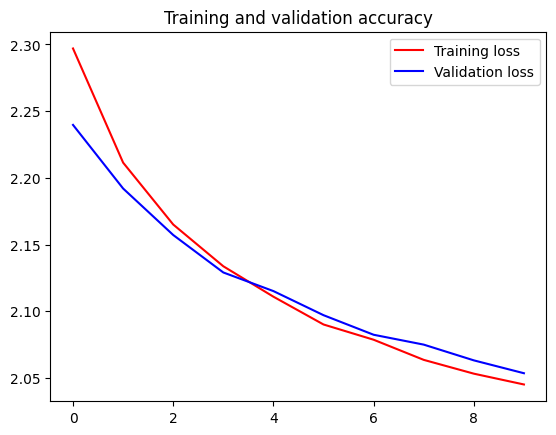

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_loss_accuracy('As it is model')

In [ ]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# FINETUNING METHOD.


* One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.
*     Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.


*   Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.





BASE MODEL B

In [ ]:
# You can easily create another base model from a pretrained network or just unfreeze the existing base model
# Also remember, make sure you have done method 1 (Use as it is) before you do method 2 - Finetuning
# Since you already have your final model(top layers) pre-trained from method 1, then you can simply just unfreeze base model and retrain network.
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  190


In [ ]:
# Freeze select top layers
fine_tune = 120
for layer in base_model.layers[:fine_tune]:
  layer.trainable = False

# Compile model - Existing model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model summary
model.summary()

# Lenght of trainable layers
len(model.trainable_variables)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490 

66

In [ ]:
# Train network
history_fine = model.fit(train_ds,
                         epochs=70,
                         initial_epoch=history.epoch[-1], # It continues training from where it left off 
                         validation_data=val_ds)

Observation: Overfitting - We can easily experience overfitting when using transfer learning, so let's make some modifications to our model for better results.

In [ ]:
history = history_fine
plot_loss_accuracy('Finetune')